### Get a simple GCN Working

In [12]:
import torch
import pickle
import numpy as np
import networkx as nx
import torchvision

# Load data splits
dataset = 'fer2013' # 'ck' or 'fer2013'
train_data_path = dataset + '_data/train_data_70_20_10.pkl'
val_data_path = dataset + '_data/val_data_70_20_10.pkl'
test_data_path = dataset + '_data/test_data_70_20_10.pkl'

with open(train_data_path, 'rb') as f:
    train_data = pickle.load(f)
with open(val_data_path, 'rb') as f:
    val_data = pickle.load(f)
with open(test_data_path, 'rb') as f:
    test_data = pickle.load(f)

adjacency_matrix = np.loadtxt('standard_mesh_adj_matrix.csv', delimiter=',')
G = nx.from_numpy_array(adjacency_matrix)

# Add batch attribute to each data object
for data in train_data:
    data.batch = torch.zeros(data.x.size(0), dtype=torch.long)
for data in val_data:
    data.batch = torch.zeros(data.x.size(0), dtype=torch.long)
for data in test_data:
    data.batch = torch.zeros(data.x.size(0), dtype=torch.long)

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import ChebConv, global_mean_pool
from torch_geometric.loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import pandas as pd

class SimpleGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, K):
        super(SimpleGCN, self).__init__()
        self.conv1 = ChebConv(input_dim, hidden_dim, K)
        self.conv2 = ChebConv(hidden_dim, hidden_dim, K)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x.to(torch.float), data.edge_index.to(torch.int64), data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)  # Global mean pool to get graph-level representation
        x = self.lin(x)
        return F.log_softmax(x, dim=1)

# Convert data lists to DataLoader
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define the training and evaluation functions
def train():
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += pred.eq(data.y).sum().item()
        total += data.y.size(0)
    return total_loss / len(train_loader), correct / total

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += pred.eq(data.y).sum().item()
            total += data.y.size(0)
            val_loss += criterion(out, data.y).item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
    return correct / total, val_loss / len(loader), all_labels, all_preds

# Get number of classes
output_dim = len(np.unique([data.y.item() for data in train_data]))

# Initialize model, optimizer, and criterion
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleGCN(input_dim=3, hidden_dim=32, output_dim=output_dim, K=3).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Calculate class weights
label_counts = np.bincount([data.y.item() for data in train_data])
class_weights = 1.0 / label_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

early_stopping = EarlyStopping(patience=10, delta=0.001)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(1, 501):
    train_loss, train_acc = train()
    val_acc, val_loss, _, _ = evaluate(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Train Acc: {int(100 * train_acc):02d}%, Val Acc: {int(100 * val_acc):02d}%')
    
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

Epoch: 001, Train Loss: 1.9425, Val Loss: 1.9388, Train Acc: 15%, Val Acc: 09%
Epoch: 002, Train Loss: 1.9410, Val Loss: 1.8926, Train Acc: 17%, Val Acc: 19%
Epoch: 003, Train Loss: 1.9364, Val Loss: 1.8567, Train Acc: 24%, Val Acc: 29%
Epoch: 004, Train Loss: 1.9335, Val Loss: 1.8934, Train Acc: 27%, Val Acc: 27%
Epoch: 005, Train Loss: 1.9281, Val Loss: 1.8953, Train Acc: 33%, Val Acc: 27%
Epoch: 006, Train Loss: 1.9199, Val Loss: 1.8404, Train Acc: 34%, Val Acc: 32%
Epoch: 007, Train Loss: 1.9037, Val Loss: 1.8344, Train Acc: 36%, Val Acc: 38%
Epoch: 008, Train Loss: 1.8896, Val Loss: 1.7815, Train Acc: 37%, Val Acc: 40%
Epoch: 009, Train Loss: 1.8733, Val Loss: 1.7892, Train Acc: 37%, Val Acc: 30%
Epoch: 010, Train Loss: 1.8619, Val Loss: 1.7734, Train Acc: 36%, Val Acc: 40%
Epoch: 011, Train Loss: 1.8541, Val Loss: 1.7268, Train Acc: 37%, Val Acc: 42%
Epoch: 012, Train Loss: 1.8433, Val Loss: 1.7259, Train Acc: 37%, Val Acc: 37%
Epoch: 013, Train Loss: 1.8413, Val Loss: 1.7796, Tr

<All keys matched successfully>

Test Accuracy: 39.45%


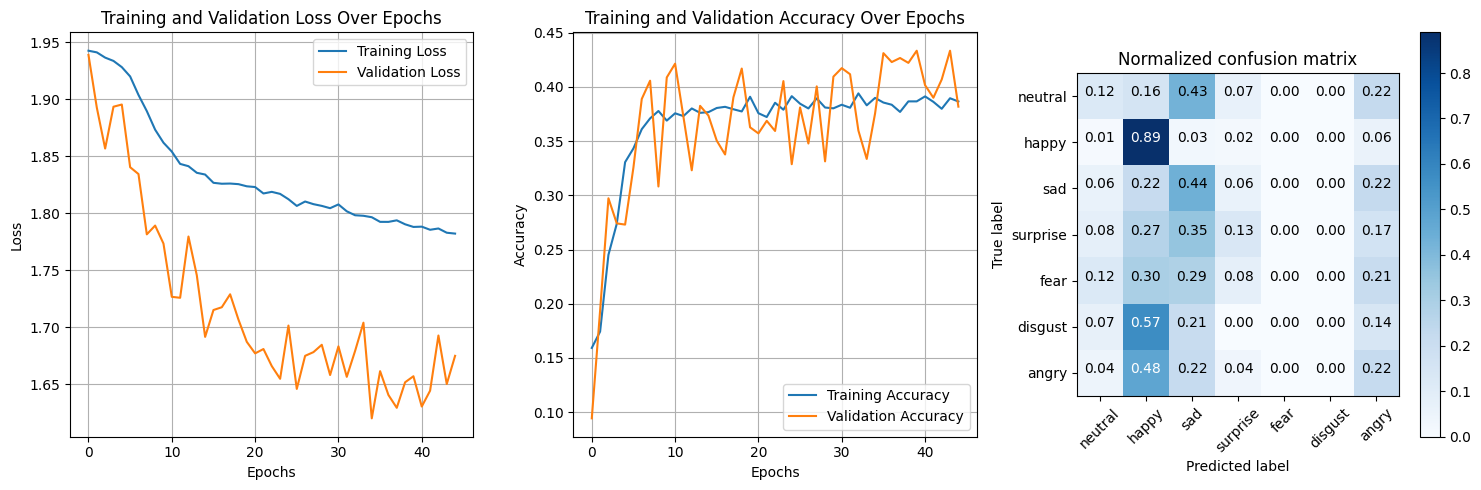

              precision    recall  f1-score      support
neutral        0.426966  0.123779  0.191919   307.000000
happy          0.583196  0.889447  0.704478   398.000000
sad            0.240000  0.435233  0.309392   193.000000
surprise       0.236111  0.133858  0.170854   127.000000
fear           0.000000  0.000000  0.000000   139.000000
disgust        0.000000  0.000000  0.000000    14.000000
angry          0.161435  0.220859  0.186528   163.000000
accuracy       0.394482  0.394482  0.394482     0.394482
macro avg      0.235387  0.257597  0.223310  1341.000000
weighted avg   0.347361  0.394482  0.336403  1341.000000


In [20]:
# Evaluate on the test set
test_acc, _, test_labels, test_preds = evaluate(test_loader)
print(f'Test Accuracy: {100 * test_acc:.2f}%')

plt.figure(figsize=(15, 5))

# Plotting training and validation loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
# plt.show()

# Plotting training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
# plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, test_preds)
if dataset == 'ck':
    label_mapping = {'neutral': 0, 'happiness': 1, 'sadness': 2, 'surprise': 3, 'fear': 4, 'disgust': 5, 'anger': 6, 'contempt': 7}
elif dataset == 'fer2013':
    label_mapping = {'neutral': 0, 'happy': 1, 'sad': 2, 'surprise': 3, 'fear': 4, 'disgust': 5, 'angry': 6}
class_names = [name for name in label_mapping.keys()]

# Plot normalized confusion matrix
plt.subplot(1, 3, 3)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

# Classification report
report = classification_report(test_labels, test_preds, target_names=class_names, output_dict=True, zero_division=0)

# Convert report to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Save report to CSV
# report_df.to_csv('classification_report.csv', index=True)